In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
os.environ['ENABLE_JSON_LOGGING'] = 'true'
os.environ['LOGLEVEL'] = 'DEBUG'

In [4]:
import waterhealer as wh
from waterhealer import Stream
import json
import time
import logging

wh.__version__

'0.1.5'

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes = False)
client = Client(cluster)
client

{"written_at": "2021-11-24T10:56:50.728Z", "written_ts": 1637751410728936000, "msg": "Using selector: KqueueSelector", "type": "log", "logger": "asyncio", "thread": "MainThread", "level": "DEBUG", "module": "selector_events", "line_no": 58, "function_name": null, "emit_id": null}
{"written_at": "2021-11-24T10:56:50.901Z", "written_ts": 1637751410901548000, "msg": "Using selector: KqueueSelector", "type": "log", "logger": "asyncio", "thread": "IO loop", "level": "DEBUG", "module": "selector_events", "line_no": 58, "function_name": null, "emit_id": null}


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://192.168.68.103:8787/status,
Status: running,Using processes: False
Dashboard: http://192.168.68.103:8787/status,Workers: 1
Total threads: 8,Total memory: 16.00 GiB
Comm: inproc://192.168.68.103/72088/1,Workers: 1
Dashboard: http://192.168.68.103:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: inproc://192.168.68.103/72088/3,Total threads: 8
Dashboard: http://192.168.68.103:58874/status,Memory: 16.00 GiB
Nanny: None,


In [6]:
from datetime import datetime

class Persistent:
    def __init__(self):
        # initiate GCS / S3 client
        pass
    
    def persist(self, data, now):
        """
        data: Dict[function, args, kwargs, exception, error, key]
        timestamp: datetime.datetime
            from `datetime.now()`.
        """
        now = datetime.strftime(now, '%y-%m-%d-%H-%M-%S')
        with open(f"{data['function']}-{now}.json", 'w') as fopen:
            json.dump(data, fopen)
        
        # also can do webhook for real time alert

In [7]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append(json.loads(row))
    return results

def increment_left(rows):
    results = []
    for row in rows:
        row = row.copy()
        row['left'] = row['data'] + 1
        results.append(row)
    return results

def increment_right(rows):
    results = []
    for row in rows:
        row = row.copy()
        row['right'] = row['data'] + 1
        results.append(row)
    return results

def combine(tuples):
    raise Exception('error')

In [8]:
source = Stream()
partition = source.scatter().partition_time(0.5, checkpoint = True)
s = partition.map(json_loads, checkpoint = True)
left = s.map(increment_left, checkpoint = True)
right = s.map(increment_right, checkpoint = True)
gather = left.zip(right).map(combine, checkpoint = True).buffer(8).gather()

In [9]:
wh.dask_plugin.remote_logging(client, Persistent)

{"written_at": "2021-11-24T10:56:51.775Z", "written_ts": 1637751411775349000, "msg": "run ['dot', '-Tpng']", "type": "log", "logger": "graphviz.backend", "thread": "MainThread", "level": "DEBUG", "module": "backend", "line_no": 153, "function_name": null, "emit_id": null}


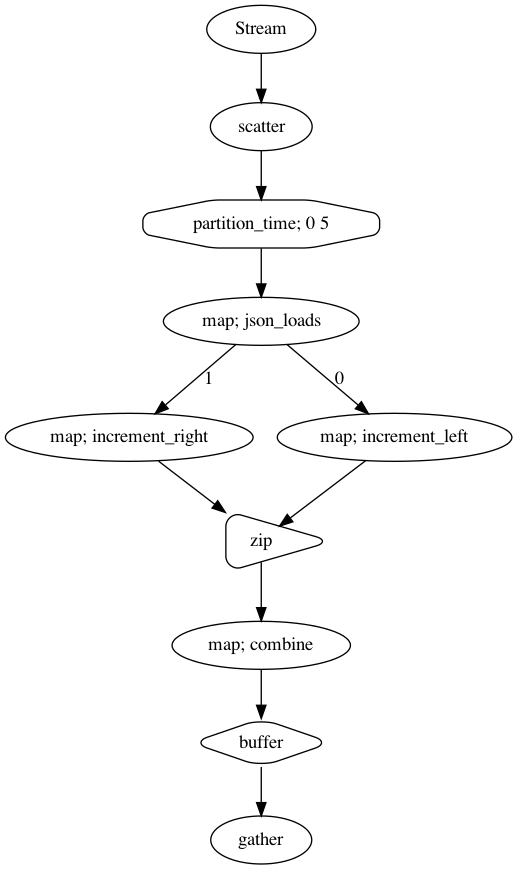

In [10]:
source.visualize()

In [11]:
for i in range(5):
    data = {'i': i, 'data': i + 1}
    source.emit(json.dumps(data))
    time.sleep(0.1)

{"written_at": "2021-11-24T10:56:52.026Z", "written_ts": 1637751412026179000, "msg": "{'function_name': 'Stream', 'data': '{\"i\": 0, \"data\": 1}'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "2ac897b7-e19d-4563-8fc5-1b25006c8bed"}
{"written_at": "2021-11-24T10:56:52.031Z", "written_ts": 1637751412031872000, "msg": "{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.str, key: str-a1d3603fdc224ea5bf189b67ed2ecc9f>'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "2ac897b7-e19d-4563-8fc5-1b25006c8bed"}
{"written_at": "2021-11-24T10:56:52.134Z", "written_ts": 1637751412134699000, "msg": "{'function_name': 'Stream', 'data': '{\"i\": 1, \"data\": 2}'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "5b9603d3-34d9-42ba-9e00-10767df46dbe"}
{"written_at": "2021

{"written_at": "2021-11-24T10:56:52.337Z", "written_ts": 1637751412337165000, "msg": "Compute Failed_Function:  combine_args:      (([{'i': 0, 'data': 1, 'left': 2}, {'i': 1, 'data': 2, 'left': 3}, {'i': 2, 'data': 3, 'left': 4}], [{'i': 0, 'data': 1, 'right': 2}, {'i': 1, 'data': 2, 'right': 3}, {'i': 2, 'data': 3, 'right': 4}]))_kwargs:    {}_Exception: Exception('error')_", "type": "log", "logger": "distributed.worker", "thread": "IO loop", "level": "WARNING", "module": "worker", "line_no": 2963, "function_name": null, "emit_id": null}
{"written_at": "2021-11-24T10:56:52.347Z", "written_ts": 1637751412347880000, "msg": "Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x11d621a70>, <Future finished exception=Exception('error')>)", "type": "log", "logger": "tornado.application", "thread": "IO loop", "level": "ERROR", "module": "ioloop", "line_no": 801, "function_name": null, "emit_id": null}


{"written_at": "2021-11-24T10:56:52.362Z", "written_ts": 1637751412362930000, "msg": "{'function_name': 'Stream', 'data': '{\"i\": 3, \"data\": 4}'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "29d522a2-233b-43e8-ae14-7af7aef02d4e"}
{"written_at": "2021-11-24T10:56:52.366Z", "written_ts": 1637751412366369000, "msg": "{'function_name': 'scatter', 'data': '<Future: finished, type: builtins.str, key: str-d26c89c4c6c149cdafffe902a6c7f572>'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "29d522a2-233b-43e8-ae14-7af7aef02d4e"}
{"written_at": "2021-11-24T10:56:52.473Z", "written_ts": 1637751412473537000, "msg": "{'function_name': 'Stream', 'data': '{\"i\": 4, \"data\": 5}'}", "type": "log", "logger": "root", "thread": "IO loop", "level": "INFO", "module": "core", "line_no": 509, "emit_id": "cc67404d-9533-4e8b-a124-3b059d4fea23"}
{"written_at": "2021

{"written_at": "2021-11-24T10:56:52.848Z", "written_ts": 1637751412848774000, "msg": "Compute Failed_Function:  combine_args:      (([{'i': 3, 'data': 4, 'left': 5}, {'i': 4, 'data': 5, 'left': 6}], [{'i': 3, 'data': 4, 'right': 5}, {'i': 4, 'data': 5, 'right': 6}]))_kwargs:    {}_Exception: Exception('error')_", "type": "log", "logger": "distributed.worker", "thread": "IO loop", "level": "WARNING", "module": "worker", "line_no": 2963, "function_name": null, "emit_id": null}
